## Part 1: Regression Task:

### Data Preprocess

# 1. Data exploration

In [1]:
# Import libraris and dataset
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing

df = pd.read_csv('bikesharing.csv')

# 2. Missing data

In [2]:
df.isnull().sum()
df = df.fillna(df.mean())

In [3]:
df = df.drop(['casual','instant','dteday','registered'],axis = 1)

seed = 1498920
np.random.seed(seed)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


# 3. Splitting data

In [5]:
# Split train test 70%
bool_index = np.random.rand(df.shape[0]) < 0.7
train = df[bool_index].reset_index(drop = True)
test = df[~bool_index].reset_index(drop = True)

# 4. Scaling data

In [6]:
# X features and y
# Standardize X features
scaler = preprocessing.StandardScaler()


train_x = train.iloc[:,0:12]
train_y = train.iloc[:,12]
scaler.fit(train_x)
train_x_scaled = scaler.transform(train_x)

test_x = test.iloc[:,0:12]
test_y = test.iloc[:,12] 
test_x_scaled = scaler.transform(test_x)

# 5. Bagging

In [7]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(random_state=0)
bag_reg = BaggingRegressor(dt_reg, n_estimators=500, max_samples=100, bootstrap=True, random_state=0, oob_score=True)

bag_reg.fit(train_x_scaled, train_y)
y_pred = bag_reg.predict(test_x_scaled)

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test_y, y_pred))
rms

103.83903402376203

In [9]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(random_state=0)
bag_rnd = BaggingRegressor(rnd_reg, n_estimators=500, max_samples=100, bootstrap=True, random_state=0, oob_score=True)

bag_rnd.fit(train_x_scaled, train_y)

y_pred_rf = bag_rnd.predict(test_x_scaled)

rms = sqrt(mean_squared_error(test_y, y_pred_rf))
rms

113.82936972085706

# 6. Pasting

In [13]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(random_state=0)
bag_reg = BaggingRegressor(dt_reg, n_estimators=500, max_samples=100, bootstrap=False, random_state=0)

bag_reg.fit(train_x_scaled, train_y)
y_pred = bag_reg.predict(test_x_scaled)

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test_y, y_pred))
rms

103.74226374247431

In [15]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(random_state=0)
bag_rnd = BaggingRegressor(rnd_reg, n_estimators=500, max_samples=100, bootstrap=False, random_state=0)

bag_rnd.fit(train_x_scaled, train_y)

y_pred_rf = bag_rnd.predict(test_x_scaled)

rms = sqrt(mean_squared_error(test_y, y_pred_rf))
rms

113.75255512203731

# 7. AdaBoost

In [16]:
from sklearn.ensemble import AdaBoostRegressor

dt_reg = DecisionTreeRegressor(random_state=0)
ada_reg = AdaBoostRegressor(dt_reg)

ada_reg.fit(train_x_scaled, train_y)
y_pred_ada = bag_reg.predict(test_x_scaled)
rms = sqrt(mean_squared_error(test_y, y_pred_ada))
rms

103.74226374247431

In [17]:
dt_reg = RandomForestRegressor(random_state=0, max_depth = 1, max_leaf_nodes=2, min_samples_split=2)
ada_reg = AdaBoostRegressor(dt_reg)

ada_reg.fit(train_x_scaled, train_y)
y_pred = bag_reg.predict(test_x_scaled)
rms = sqrt(mean_squared_error(test_y, y_pred))
rms

103.74226374247431

# 8. Gradient Boosting

In [20]:
# GridSearch
from sklearn.model_selection import GridSearchCV
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
gb = GradientBoostingRegressor(random_state=42)

param = {'max_depth':[1,2,3], 'n_estimators':[100,200], 'learning_rate':[0.8, 1.0]}
gb_grid_search = GridSearchCV(gb, param, cv=5)
gb_grid_search.fit(train_x_scaled, train_y)
print("Best parameters: {}".format(gb_grid_search.best_params_))
print("Best cross-validation score: {:.4f}".format(gb_grid_search.best_score_))

# Cross-validation
gb_scores = cross_val_score(gb, train_x_scaled, train_y, cv=5)
print("Average cross-validation score: {:.4f}".format(gb_scores.mean()))

Best parameters: {'learning_rate': 0.8, 'max_depth': 2, 'n_estimators': 200}
Best cross-validation score: 0.7766
Average cross-validation score: 0.7463


In [21]:
gb = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.8, random_state=42)
gb.fit(train_x_scaled, train_y)
y_pred_gb = gb.predict(test_x_scaled)

rms = sqrt(mean_squared_error(test_y, y_pred_gb))
rms

66.5177573922792

# 9. Applying PCA and running all algorithms from Project 1

In [22]:
from sklearn.decomposition import PCA

# 0.90 = 90% variance retained
pca = PCA(0.90)
# fit on train set only
pca.fit(train_x_scaled)

# transform for both train and test
pca_train_x = pca.transform(train_x_scaled)
pca_test_x = pca.transform(test_x_scaled)

In [23]:
print(train_x_scaled.shape)
print(pca_train_x.shape)

# 90% variance is retained by using 9 components (variables)

(12126, 12)
(12126, 9)


### Regression models using GridSearchCV and cross-validation

1. SVM kernel (linear, poly, rbf)

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svclassifier = SVR()
param_grid = {'kernel' : ['linear','poly', 'rbf']}

grid_search_SVR = GridSearchCV(estimator = svclassifier, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 10,return_train_score = True)


grid_search_SVR.fit(pca_train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   18.5s remaining:   37.2s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   21.0s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   32.7s remaining:   26.1s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   32.9s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   37.3s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   46.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   46.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=10)

In [25]:
import matplotlib.pyplot as plt

results = grid_search_SVR.cv_results_
num_param = len(list(param_grid.values())[0])
train_scores = np.hstack((results['split0_train_score'].reshape((num_param,1)),results['split1_train_score'].reshape((num_param,1)),results['split2_train_score'].reshape((num_param,1))))
val_scores = np.hstack((results['split0_test_score'].reshape((num_param,1)),results['split1_test_score'].reshape((num_param,1)),results['split2_test_score'].reshape((num_param,1))))

In [26]:
train_mean = np.mean(train_scores,axis = 1)
val_mean = np.mean(val_scores,axis = 1)  
width = 0.6

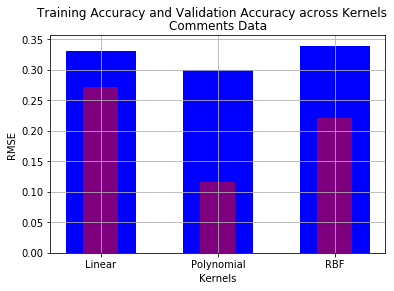

In [27]:
plt.grid(True)
plt.bar(['Linear','Polynomial','RBF'], train_mean, width=width, 
        color='b', label='Training Accuracy')
plt.bar(['Linear','Polynomial','RBF'], val_mean, 
        width=0.5*width, color='r', alpha=0.5, label='Validation Accuracy')
plt.title('Comments Data')
plt.suptitle('Training Accuracy and Validation Accuracy across Kernels')
plt.ylabel('RMSE')
plt.xlabel('Kernels')
plt.show()

In [28]:
SVM_final = grid_search_SVR.best_estimator_
pred_test_y = SVM_final.predict(pca_test_x) 

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rms = sqrt(mean_squared_error(test_y, pred_test_y))

In [30]:
rms

151.93758160270653

2. KNN

In [31]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
param_grid = {'n_neighbors' : [i for i in range(1,21,2)]}

grid_search_KNN = GridSearchCV(estimator = knn_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 10,return_train_score = True)

grid_search_KNN.fit(pca_train_x, train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   16.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.5s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=10)

In [32]:
best_k = grid_search_KNN.best_params_['n_neighbors']

results = grid_search_KNN.cv_results_
num_param = len(list(param_grid.values())[0])
train_scores = np.hstack((results['split0_train_score'].reshape((num_param,1)),results['split1_train_score'].reshape((num_param,1)),results['split2_train_score'].reshape((num_param,1))))
val_scores = np.hstack((results['split0_test_score'].reshape((num_param,1)),results['split1_test_score'].reshape((num_param,1)),results['split2_test_score'].reshape((num_param,1))))

In [33]:
train_mean = np.mean(train_scores,axis = 1)
val_mean = np.mean(val_scores,axis = 1)  
width = 0.6

Text(0.5, 0, 'Number of Neighbors')

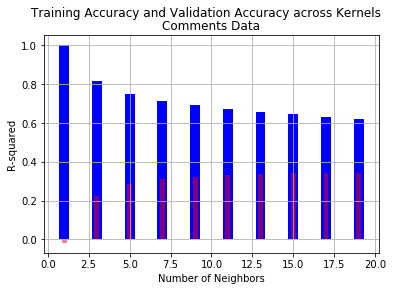

In [34]:
plt.grid(True)
plt.bar( [i for i in range(1,21,2)], train_mean, width=width, 
        color='b', label='Training Accuracy')
plt.bar([i for i in range(1,21,2)], val_mean, 
        width=0.5*width, color='r', alpha=0.5, label='Validation Accuracy')
plt.title('Comments Data')
plt.suptitle('Training Accuracy and Validation Accuracy across Kernels')
plt.ylabel('R-squared')
plt.xlabel('Number of Neighbors')

In [36]:
KNN_final = grid_search_KNN.best_estimator_
pred_test_y = KNN_final.predict(pca_test_x)

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test_y, pred_test_y))
rms

118.1769602519825

3. Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
linreg_model.fit(pca_train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
import statsmodels.formula.api as sm
import statsmodels.api as sm

linreg_model = sm.OLS(train_y,pca_train_x).fit()

In [41]:
#results = linreg_model.fit()
#results.params

In [42]:
linreg_model.summary()

pred_test_y = linreg_model.predict(pca_test_x)

In [43]:
rms = sqrt(mean_squared_error(test_y, pred_test_y))
rms

239.51366865837832

In [44]:
from sklearn.base import BaseEstimator

class PolynomialRegression(BaseEstimator):
    def __init__(self, deg=None):
        self.deg = deg
    
    def fit(self, X, y, deg=None):
        self.model = LinearRegression(fit_intercept=False)
        self.model.fit(np.vander(X, N=self.deg + 1), y)
    
    def predict(self, x):
        return self.model.predict(np.vander(x, N=self.deg + 1))
    
    @property
    def coef_(self):
        return self.model.coef_

In [45]:
poly_reg = PolynomialRegression()
degrees = np.arange(1, 8)
grid_search_poly = GridSearchCV(poly_reg,
                        param_grid={'deg': degrees},
                        scoring='neg_mean_squared_error')
grid_search_poly.fit(train_y, pca_train_x)
grid_search_poly.best_estimator_

PolynomialRegression(deg=5)

In [46]:
best_degree = grid_search_poly.best_params_['deg']
poly_final = grid_search_poly.best_estimator_

In [47]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=best_degree)
train_x_poly = poly.fit_transform(pca_train_x)
poly_lr = LinearRegression()
poly_lr.fit(train_x_poly, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
test_x_poly = poly.fit_transform(pca_test_x)

pred_test_y = poly_lr.predict(test_x_poly)
rms = sqrt(mean_squared_error(test_y, pred_test_y))
rms

1606.3532361836228

4. Ridge

In [49]:
from sklearn.linear_model import Ridge, Lasso

ridge_model = Ridge()

param_grid = {'alpha' : np.arange(0.5,2.0,0.2)}

grid_search_ridge = GridSearchCV(estimator = ridge_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 10,return_train_score = True)

grid_search_ridge.fit(pca_train_x, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0624s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   5 out of  24 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  24 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=10)

In [50]:
best_alpha = grid_search_ridge.best_params_['alpha']

ridge_final = grid_search_ridge.best_estimator_
pred_test_y = ridge_final.predict(pca_test_x)

rms = sqrt(mean_squared_error(test_y, pred_test_y))
rms

144.82485410842116

5. Lasso

In [51]:
lasso_model = Lasso()

param_grid = {'alpha' : np.arange(0.5,2.0,0.2)}

grid_search_lasso = GridSearchCV(estimator = lasso_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 10,return_train_score = True)

grid_search_lasso.fit(pca_train_x, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0585s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   5 out of  24 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  24 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=10)

In [52]:
best_alpha = grid_search_lasso.best_params_['alpha']

lasso_final = grid_search_lasso.best_estimator_
pred_test_y = lasso_final.predict(pca_test_x)

rms = sqrt(mean_squared_error(test_y, pred_test_y))
rms

144.8266162413143

# Result Table before and after applying PCA 

In [86]:
print('Before PCA:')

data1 = {'Model Selection':["KNN", "Linear Regression", "SVR Kernel RBF", "Polynomial Regression", "Ridge Regression", "Lasso Regression"],
       'Best cross-validation RMSE':[116, 224, 154, 324, 186, 172]}
data2 = {'Model Selection':["KNN", "Linear Regression", "SVR Kernel RBF", "Polynomial Regression", "Ridge Regression", "Lasso Regression"],
       'RMSE after PCA':[118, 239, 151, 1606, 144, 144]}

df1 = pd.DataFrame(data1)
df1.sort_values(['Best cross-validation RMSE'], ascending=True)

Before PCA:


,Model Selection,Best cross-validation RMSE
0,KNN,116
2,SVR Kernel RBF,154
5,Lasso Regression,172
4,Ridge Regression,186
1,Linear Regression,224
3,Polynomial Regression,324


In [87]:
print('After PCA:')

df2 = pd.DataFrame(data2)
df2.sort_values(['RMSE after PCA'], ascending=True)

After PCA:


,Model Selection,RMSE after PCA
0,KNN,118
4,Ridge Regression,144
5,Lasso Regression,144
2,SVR Kernel RBF,151
1,Linear Regression,239
3,Polynomial Regression,1606


Result Comparison Table (Before PCA vs After PCA)

In [65]:
data = {'Model Selection':["KNN", "Linear Regression", "SVR Kernel RBF", "Polynomial Regression", "Ridge Regression", "Lasso Regression"],
       'Best cross-validation RMSE':[116, 224, 154, 324, 186, 172],
       'Best cross-validation RMSE after PCA':[118, 239, 151, 1606, 144, 144]}

df = pd.DataFrame(data)
df.sort_values(['Best cross-validation RMSE'], ascending=True)

,Model Selection,Best cross-validation RMSE,Best cross-validation RMSE after PCA
0,KNN,116,118
2,SVR Kernel RBF,154,151
5,Lasso Regression,172,144
4,Ridge Regression,186,144
1,Linear Regression,224,239
3,Polynomial Regression,324,1606


KNN is the best model as it provides the best model results with the lowest cross-validation RMSE (both before and after PCA). PCA doesn't help in getting better results in this dataset as the cross-validation RMSE after PCA seem to be higher in general compared to those before PCA. Since we aim to have a model that runs fast and is easy to implement, KNN is the best model to be selected. It also requires no assumption and only uses one hyperparameter.

# 10. Applying Neural Network

In [88]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [89]:
train_x.shape

(12126, 12)

In [90]:
# Define the keras model
model = Sequential()

# Hidden layers
model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))

# Output
model.add(Dense(1, kernel_initializer='normal',))

In [91]:
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [92]:
# Train the model: fit epochs and batch_size
model.fit(train_x_scaled, train_y, epochs = 10, batch_size = 5)

Epoch 1/10
12126/12126 [==============================] - 5s 423us/step - loss: 46899.1513
Epoch 2/10
12126/12126 [==============================] - 6s 526us/step - loss: 23051.1178
Epoch 3/10
12126/12126 [==============================] - 7s 542us/step - loss: 20678.7490
Epoch 4/10
12126/12126 [==============================] - 7s 544us/step - loss: 19705.5033
Epoch 5/10
12126/12126 [==============================] - 5s 453us/step - loss: 19404.6318
Epoch 6/10
12126/12126 [==============================] - 6s 482us/step - loss: 19323.7343
Epoch 7/10
12126/12126 [==============================] - 6s 480us/step - loss: 19292.0175
Epoch 8/10
12126/12126 [==============================] - 5s 454us/step - loss: 19277.6221
Epoch 9/10
12126/12126 [==============================] - 6s 468us/step - loss: 19262.5476
Epoch 10/10
12126/12126 [==============================] - 6s 476us/step - loss: 19241.8433


We have improved our loss from 46899.1513 to 19241.8433.

In [93]:
# Evaluation
model.evaluate(train_x_scaled, train_y)

12126/12126 [==============================] - 0s 37us/step


19208.477147744903

In [94]:
model.evaluate(test_x_scaled, test_y)

5253/5253 [==============================] - 0s 26us/step


20341.76542106148

In [99]:
# Making predictions
test_y_predictions = model.predict(test_x_scaled)
test_y_predictions

array([[ 36.491898],
       [ 80.924904],
       [ 86.71492 ],
       ...,
       [ 95.54914 ],
       [186.18881 ],
       [220.76636 ]], dtype=float32)